In [1]:
# Import modules for building a neural operator model
import numpy as np
import scipy as sp
import torch
import torch.optim as optim

# Import specialized neural operator model tools
from neuralop.models import FNO, TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.datasets import data_transforms
from neuralop import LpLoss, H1Loss

# For creating datasets and data loaders for training and evaluation
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# Optional: torchvision for augmentations and transformations (if working with image-like data)
import torchvision.transforms as transforms

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: Use tqdm for progress bars during training and evaluation
from tqdm import tqdm

# For handling file paths and directories
import os
import sys
import h5py

# Optional: If your model or data processing requires specific numerical operations (e.g., FFT)
from torch.fft import fft, ifft

# Optional: If you are working with graph data or architectures
# import torch_geometric

# If you need automatic differentiation for custom operations or gradients
from torch.autograd import Function


In [2]:
#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

Using Device: cuda
Using PyTorch version: 2.1.0


In [6]:
#Load the data for the neural operator model
datafolder_name = ["OUTPUT","preliminary_datasets"]
datafile_name = "DATA N_pix32x32 N_ele1x1 N_wv25x13 N_disp100 N_eig6 offset0 01-Mar-2024 19-13-23.mat"
data_path = os.path.join(*datafolder_name, datafile_name)
print(data_path)

# Load the .mat file using h5py
with h5py.File(data_path, 'r') as file:
    # print(file['EIGENVECTOR_DATA'].dtype.names)
    # print(file['EIGENVALUE_DATA'].dtype.names)
    # print(file['WAVEVECTOR_DATA'].dtype.names)
    # Load the data arrays
    EIGENVALUE_DATA = np.array(file['EIGENVALUE_DATA'], dtype=np.float16)
    EIGENVECTOR_DATA_real = np.array(file['EIGENVECTOR_DATA']['real'], dtype=np.float16)
    EIGENVECTOR_DATA_imag = np.array(file['EIGENVECTOR_DATA']['imag'], dtype=np.float16)
    EIGENVECTOR_DATA = EIGENVECTOR_DATA_real + 1j * EIGENVECTOR_DATA_imag
    WAVEVECTOR_DATA = np.array(file['WAVEVECTOR_DATA'], dtype=np.float16)

    # Convert to PyTorch tensors
    EIGENVALUE_DATA_tensor = torch.tensor(EIGENVALUE_DATA, dtype=torch.float16)
    EIGENVECTOR_DATA_tensor = torch.tensor(EIGENVECTOR_DATA, dtype=torch.complex32)
    WAVEVECTOR_DATA_tensor = torch.tensor(WAVEVECTOR_DATA, dtype=torch.float16)

    # Unpack the 'const' struct
    # This assumes 'const' contains datasets directly. If it contains groups, you'll need to adjust the code
    const = {key: np.array(file['const'][key]) for key in file['const']}

    # Assign numbers to variables
    N_struct = np.array(file['N_struct'])  # Adjust indexing if necessary
    design_params = np.array(file['design_params'])
    designs = np.array(file['designs'])
    imag_tol = np.array(file['imag_tol'])
    rng_seed_offset = np.array(file['rng_seed_offset'])

OUTPUT\preliminary_datasets\DATA N_pix32x32 N_ele1x1 N_wv25x13 N_disp100 N_eig6 offset0 01-Mar-2024 19-13-23.mat


C:\Users\zhang\AppData\Local\Temp\ipykernel_14568\3278998178.py:21: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\EmptyTensor.cpp:32.)
  EIGENVECTOR_DATA_tensor = torch.tensor(EIGENVECTOR_DATA, dtype=torch.complex32)


In [7]:
# Print shapes or values to verify
print("EIGENVALUE_DATA shape:", EIGENVALUE_DATA_tensor.shape)
print("EIGENVECTOR_DATA shape:", EIGENVECTOR_DATA_tensor.shape) #Complex valued, 32x32 nodes, 2 DoF per node, 100 structs, 6 bands
print("WAVEVECTOR_DATA shape:", WAVEVECTOR_DATA_tensor.shape)
#print("const contents:", const)
print("N_struct:", N_struct)
print("design_params:", design_params)
print("designs:", designs)
print("imag_tol:", imag_tol)
#print("rng_seed_offset:", rng_seed_offset)

EIGENVALUE_DATA shape: torch.Size([100, 6, 325])
EIGENVECTOR_DATA shape: torch.Size([100, 6, 325, 2048])
WAVEVECTOR_DATA shape: torch.Size([100, 2, 325])
N_struct: [[100.]]
design_params: [[3707764736          2          1          1          2          2]]
designs: [[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0. 

In [8]:
def plot_histograms(array_slice):
    """
    Plots histograms for the input array slice.
    If the array slice contains real numbers, plots one histogram.
    If the array slice contains complex numbers, plots two histograms side by side,
    one for the real parts and one for the imaginary parts.
    """
    # Check if the array slice contains complex numbers
    if np.iscomplexobj(array_slice):
        # Prepare the plot area with two subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        # Plot histogram of real parts
        axs[0].hist(array_slice.real, bins=100, color='skyblue', edgecolor='black')
        axs[0].set_title('Histogram of Real Parts')

        # Plot histogram of imaginary parts
        axs[1].hist(array_slice.imag, bins=100, color='salmon', edgecolor='black')
        axs[1].set_title('Histogram of Imaginary Parts')

        plt.suptitle('Histograms of Complex Array Slice')
    else:
        # Plot a single histogram for real-valued array slice
        plt.figure(figsize=(6, 6))
        plt.hist(array_slice, bins=30, color='skyblue', edgecolor='black')
        plt.title('Histogram of Real Array Slice')

    plt.show()

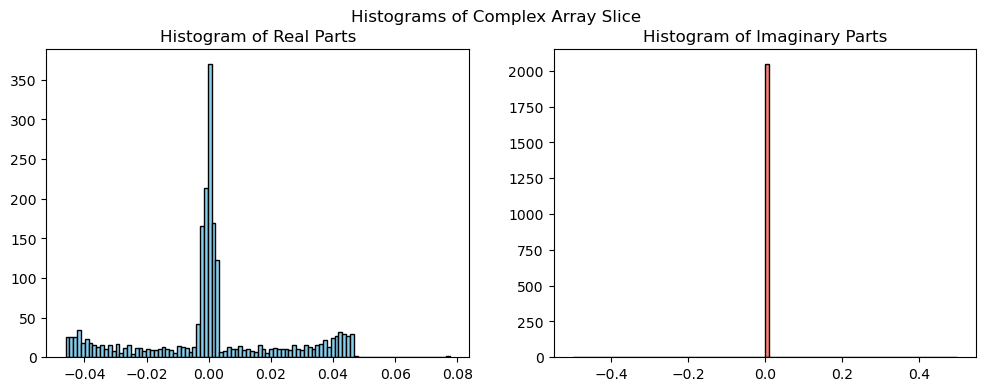

In [11]:
struct = 20
band = 3
wavevector = 0
node = 0
plot_histograms(EIGENVECTOR_DATA[struct, band, wavevector, :])
#plot_histograms(WAVEVECTOR_DATA[struct, 0, :])

In [16]:
class NormalizeOutput:
    def __init__(self, mean=None, std=None):
        self.mean = mean
        self.std = std

    def fit(self, outputs):
        """Calculate mean and std deviation from the dataset if not provided."""
        if self.mean is None or self.std is None:
            self.mean = outputs.mean(axis=0)
            self.std = outputs.std(axis=0)

    def transform(self, outputs):
        """Normalize the outputs."""
        return (outputs - self.mean) / self.std

    def inverse_transform(self, normalized_outputs):
        """Reverse the normalization to get the original scale of outputs."""
        return normalized_outputs * self.std + self.mean


In [77]:
# Use designs as x_train and EIGENVECTOR_DATA as y_train
print("designs shape:", designs.shape)
print("EIGENVECTOR_DATA slice shape:", EIGENVECTOR_DATA[:,0,0,:].shape)
x_train = torch.tensor(designs, dtype=torch.float32)
y_train = EIGENVECTOR_DATA_tensor[:,0,0,:].reshape(100, 2, 32,32)
y_train = y_train[:,0,:,:]
y_train = y_train.reshape(100, 1, 32, 32)
# y_train_real = y_train.real
# y_train_imag = y_train.imag
# y_train = torch.stack((y_train_real, y_train_imag), dim=1).reshape(100, 4, 32, 32)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

designs shape: (100, 3, 32, 32)
EIGENVECTOR_DATA slice shape: (100, 2048)
x_train shape: torch.Size([100, 3, 32, 32])
y_train shape: torch.Size([100, 1, 32, 32])


In [78]:

# Normalize the outputs
# normalizer = NormalizeOutput()
# normalizer.fit(y_train.numpy())
# normalized_outputs = normalizer.transform(y_train.numpy())
# y_train = torch.tensor(normalized_outputs, dtype=torch.float32)
# print(normalizer.mean, normalizer.std)

dataset = torch.utils.data.TensorDataset(x_train, y_train)
print(torch.max(x_train), torch.min(x_train))
print(torch.max(torch.abs(y_train)), torch.min(torch.abs(y_train)))
#print(len(dataset))
# Define the sizes of train and test datasets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

tensor(1.) tensor(0.)
tensor(0.2500, dtype=torch.float16) tensor(0., dtype=torch.float16)


In [96]:
class DataLoaderWrapper:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        # Iterate over the original DataLoader
        for batch in self.dataloader:
            inputs, outputs = batch  # Unpack the batch
            # Yield a dictionary with 'inputs' and 'outputs' keys
            yield {'x': inputs, 'y': outputs}

    def __len__(self):
        # Return the length of the original DataLoader
        return len(self.dataloader)

    def items(self):
        # Return a list of tuples containing the key-value pairs
        return [('x', self.dataloader.dataset.inputs), ('y', self.dataloader.dataset.outputs)]

In [97]:
train_loader_wrapped = DataLoaderWrapper(train_loader)
test_loader_wrapped = DataLoaderWrapper(test_loader)

In [118]:
NO_model = TFNO(n_modes=(16, 16), in_channels=3, out_channels=1, hidden_channels=32, projection_channels=4)
NO_params = count_model_params(NO_model)
print(f'Neural Operator model has {NO_params} parameters.')

Neural Operator model has 1212337 parameters.


In [129]:
optimizer = torch.optim.Adam(NO_model.parameters(),
                             lr=1e-2,
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
#optimizer = torch.optim.AdamW(NO_model.parameters(), lr=1e-3, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)


In [130]:
# Make sure your model is on the correct device
NO_model.to(device)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

# Prepare dictionaries to hold training and validation losses
train_losses = []
valid_losses = {'h1': [], 'l2': []}

In [131]:
num_epochs = 200  # Specify the desired number of epochs
verbose = True  # Flag for verbosity

for epoch in range(num_epochs):
    NO_model.train()  # Set the model to training mode
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the correct device

        optimizer.zero_grad()  # Zero the gradients
        outputs = NO_model(inputs)  # Forward pass
        loss = train_loss(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        running_loss += loss.item()
        if verbose and batch_idx % 10 == 0:  # Report progress every 10 batches
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    # After each epoch, report the average loss
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} completed, Average Loss: {avg_loss}")

    # Adjust learning rate according to scheduler
    scheduler.step()

    # Evaluation phase
    NO_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        eval_loss_sum = 0.0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = NO_model(inputs)
            eval_loss = eval_losses['h1'](outputs, targets)  # Can be adjusted to other loss metrics in 'eval_losses'
            eval_loss_sum += eval_loss.item()
        avg_eval_loss = eval_loss_sum / len(test_loader)
        print(f"Validation Loss after Epoch {epoch+1}/{num_epochs}: {avg_eval_loss}\n")

Epoch 1/200, Batch 1/4, Loss: 96.8008041381836
Epoch 1/200 completed, Average Loss: 575.7813749313354
Validation Loss after Epoch 1/200: 21.15431785583496

Epoch 2/200, Batch 1/4, Loss: 43.56922149658203
Epoch 2/200 completed, Average Loss: 53.39036273956299
Validation Loss after Epoch 2/200: 12.02341365814209

Epoch 3/200, Batch 1/4, Loss: 23.356094360351562
Epoch 3/200 completed, Average Loss: 24.198159217834473
Validation Loss after Epoch 3/200: 13.744132041931152

Epoch 4/200, Batch 1/4, Loss: 27.9241886138916
Epoch 4/200 completed, Average Loss: 32.71749210357666
Validation Loss after Epoch 4/200: 12.539332866668701

Epoch 5/200, Batch 1/4, Loss: 24.458972930908203
Epoch 5/200 completed, Average Loss: 23.429738998413086
Validation Loss after Epoch 5/200: 11.023078441619873

Epoch 6/200, Batch 1/4, Loss: 23.421674728393555
Epoch 6/200 completed, Average Loss: 22.76424217224121
Validation Loss after Epoch 6/200: 11.161680698394775

Epoch 7/200, Batch 1/4, Loss: 23.53661346435547
Epo

In [132]:
def plot_sample_prediction(input_tensor, true_output_tensor, predicted_output_tensor):
    """
    Plots the input, true output, and predicted output for one sample.
    
    Assumes the input is an image with shape [3, H, W] and the outputs can be reshaped to a visualizable form.
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Input
    input_img = input_tensor.cpu().detach().numpy().transpose(1, 2, 0)
    input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())  # Normalize to [0, 1]
    axs[0].imshow(input_img)
    axs[0].set_title('Input')
    axs[0].axis('off')

    # True Output
    # Assuming the output needs reshaping or is already in a plottable shape
    true_output_img = true_output_tensor.cpu().detach().numpy().squeeze()  # Adjust as needed
    axs[1].imshow(true_output_img, cmap='viridis')
    axs[1].set_title('True Output')
    axs[1].axis('off')

    # Model Prediction
    predicted_output_img = predicted_output_tensor.cpu().detach().numpy().squeeze()  # Adjust as needed
    axs[2].imshow(predicted_output_img, cmap='viridis')
    axs[2].set_title('Model Prediction')
    axs[2].axis('off')

    plt.show()

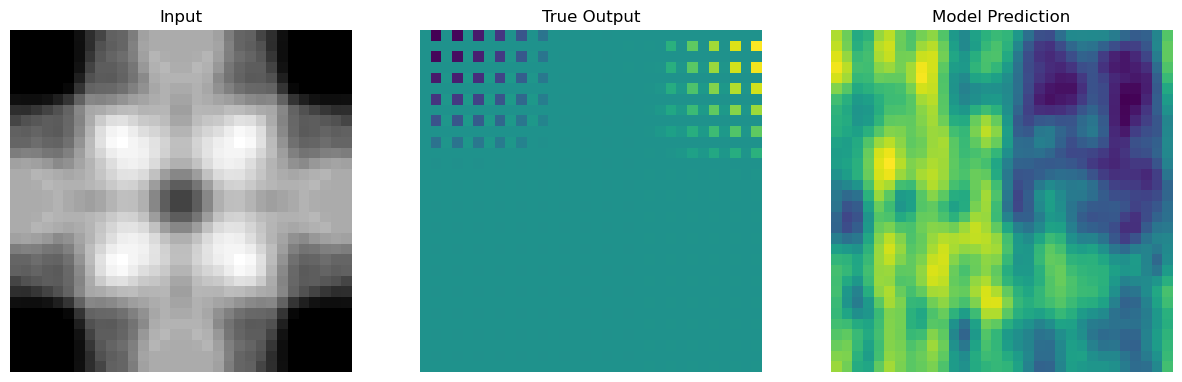

In [133]:

# Select one sample from the DataLoader
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    break  # Only take the first sample for demonstration

# Assuming the model is already trained and in evaluation mode
NO_model.eval()
with torch.no_grad():
    predictions = NO_model(inputs)

# Plotting the first sample in the batch
sample_index = 0  # Adjust if you want to visualize a different sample in the batch
plot_sample_prediction(inputs[sample_index], targets[sample_index].real, predictions[sample_index].real)


## Obsolete code below

In [100]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [101]:
print('\n### MODEL ###\n', NO_model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(16, 16, 16, 9), rank=(16, 16, 16, 9))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.losses.

In [102]:
trainer = Trainer(model=NO_model, n_epochs=1,
                  device=device,
                  #data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


In [103]:
trainer.train(train_loader=train_loader_wrapped,
              test_loaders=test_loader_wrapped,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)


AttributeError: 'Subset' object has no attribute 'inputs'

In [87]:
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)  # Move data to the same device as the model
    outputs = NO_model(inputs)
    loss = train_loss(outputs, targets)
    print(loss.item())  # Print scalar value of loss to verify
    break  # Just for demonstration, remove this in actual training


198.8743896484375


In [72]:
# Check the first batch from the train_loader
train_samples = next(iter(train_loader))
print(type(train_samples))
#print(train_samples[0])
print(f"Length of batch: {len(train_samples)}")
if isinstance(train_samples, (list, tuple)):
    # Assuming the first element is inputs and the second is targets
    print(f"Type of inputs: {type(train_samples[0])}, Shape of inputs: {train_samples[0].shape}")
    print(f"Type of targets: {type(train_samples[1])}, Shape of targets: {train_samples[1].shape}")
elif isinstance(train_samples, dict):
    # If your samples are in a dictionary format
    for key, value in train_samples.items():
        print(f"Key: {key}, Type of value: {type(value)}, Shape of value: {value.shape}")

# Repeat the process for test_loader if necessary
test_samples = next(iter(test_loader))
# Similar inspection as above for test_samples...


<class 'list'>
Length of batch: 2
Type of inputs: <class 'torch.Tensor'>, Shape of inputs: torch.Size([20, 3, 32, 32])
Type of targets: <class 'torch.Tensor'>, Shape of targets: torch.Size([20, 32, 32])


In [76]:
for batch in train_loader_wrapped:
    inputs, targets = batch['x'], batch['y']
    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)
    break  # Just check the first batch

Inputs shape: torch.Size([20, 3, 32, 32])
Targets shape: torch.Size([20, 32, 32])
